# 개요
## 주제 : 전국 지역별 맛집 정보 수집
- 전국 구별 맛집 정보 리스트화 및 도식화
- 단, 서울,인천,경기,부산 등 인구밀도가 높은 지역은 동별까지 확인할 계획(1차: 구단위 파악 / 2차: 동단위 파악)

## 작업내용
- 일전에 작업한 내용을 토대로, 음식에 대한 모든 카테고리 수집
- 코드별로 구분된 읍면동 데이터에서 '구 + 음식명' 컬럼 생성(중복의 경우, 시도명칭 포함예정)
- 각 지역구별 모든 카테고리에 해당하는 맛집 리스트 수집

## 작업방식 : 동적크롤링 활용
- [확인필] 구글맵
- [확인필] 카카오맵
- [확인필] 네이버맵
- [가능] 다이닝코드 : 크롤링이 비교적 쉽게 가능한 편이지만, 맛집 점수에 대한 신뢰도가 많이 낮은편이다
- [불가능] 망코플레이트 : 동적크롤링 페이지 넘김 불가능. 첫번째 페이지 대한 정보만으로 괜찮다면 활용이 가능은 하다

## 참고사항
- 시도/시군구/읍면동 코드 csv file / geopandas용 polygon shp파일
  - 현재 도식화를 하는 방법을 어떻게 활용할지 구성적으로도, 기술적으로도 미흡한 상태로 자료와 방법만 일단 확인해두자
- 네이버/다음 블로그 글 크롤링도 방법일것 같으나, 데이터 정리가 쉽지 않을 것 같음


# 필요패키지 호출 및 세팅

In [1]:
# 기본세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import random
import glob
import os
import geopandas as gpd

# 크롤링용
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import json
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# 컬럼, 로우 조회 최대수 지정 
pd.options.display.max_info_columns =200
pd.options.display.max_columns = 200
pd.options.display.max_info_rows =100
pd.options.display.max_rows = 100

# 시각화할때 warning 무시
import warnings
warnings.filterwarnings(action='ignore')

# 시각화시, 한글 깨짐 방지 폰트
import matplotlib.font_manager as fm
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 사전작업
1. 지역정보 호출
2. 시군구별 정리(중복 확인해서 중복있을시, 시도명칭 같이 표기) -> 새로운 컬럼생성
3. 음식리스트 확보 => 카테고리 3600개로 시간이 걸리더라도 처리가 필요(이후 작업을 위해)
4. 시군구 컬럼 + 음식리스트 호출을 편하게 할 수 있도록 정리

In [2]:
location_df = pd.read_csv('/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/adm_code.csv',engine = 'python')
location_df

,시도코드,시도명칭,시도약어,시군구코드,시군구명칭,읍면동코드,읍면동명칭,전체코드
0,11,서울특별시,서울,11010,종로구,1101053,사직동,11110101101053
1,11,서울특별시,서울,11010,종로구,1101054,삼청동,11110101101054
2,11,서울특별시,서울,11010,종로구,1101055,부암동,11110101101055
3,11,서울특별시,서울,11010,종로구,1101056,평창동,11110101101056
4,11,서울특별시,서울,11010,종로구,1101057,무악동,11110101101057
...,...,...,...,...,...,...,...,...
3488,39,제주특별자치도,제주,39020,서귀포시,3902058,서홍동,39390203902058
3489,39,제주특별자치도,제주,39020,서귀포시,3902059,대륜동,39390203902059
3490,39,제주특별자치도,제주,39020,서귀포시,3902060,대천동,39390203902060
3491,39,제주특별자치도,제주,39020,서귀포시,3902061,중문동,39390203902061


In [3]:
# 시군구 리스트 생성
location_df2 = location_df.copy()
location_df2['시군구'] = location_df2['시도약어'] + location_df2['시군구명칭']
location_df2 = location_df2['시군구']
location_df2.drop_duplicates(inplace=True)
location_df2.index = range(len(location_df2))
location_df2.loc[74] = '세종시'

In [4]:
# # 음식 food_cat 원본
# df=pd.read_csv('/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/databackup/211010_restaurant_list.csv')

# f_list = (list(df['summary']))
# f_name=[]
# for name in f_list:
#     try:
#         f_name += name.split(', ')
#     except:
#         f_name += str(name)

# # 음식이름 중복 1차 거르기
# food=[]
# for ss in f_name:
#     if ss not in food:
#         food.append(ss)
# food.sort()
# food = pd.DataFrame(food,columns=['list'])
# # food.to_excel('/Users/ppangppang/Desktop/test.xlsx')
# # 엑셀에서 중복내용 정리

In [5]:
# food_cat 정제한거

In [6]:
food_cat = pd.read_excel('/Users/ppangppang/Desktop/food_cat.xlsx')
food_cat.drop(columns='Unnamed: 0',axis=1, inplace=True)

In [7]:
food_cat.head(3)

,list
0,가라아게
1,가래떡
2,가리국밥


# 크롤링코드
- 다이닝코드, 구글맵, 카카오맵, 네이버맵

## 다이닝코드

In [ ]:
# target을 먼저 만들고 실행

search_list = target

dining_restaurant_df = pd.DataFrame()
date=str(datetime.date.today()).replace('-','')[2:]

for f_name in search_list:
    url = f'https://www.diningcode.com/list.php?query={f_name}'
    
    seed = np.random.randint(100)
    np.random.seed(seed)    
    a = np.random.randint(5)
    time.sleep(a)
    try:
        response = requests.get(url) 
    except:
        print('page error')
        break
        
    data = BeautifulSoup(response.text, 'html.parser')

    # 순위제거(상황봐서 순위 넣으려면 반복문만 주석처리)
    store = [name.text for name in data.select('span.btxt')]
    for i in range(len(store)):
        store[i] = store[i][3:]

    # 주소정보
    summary = [s_mary.text for s_mary in data.select('span.stxt')]
    sub_loca = [sub.text for sub in data.select('i.loca')]
    full_loca = [full_l.text for full_l in data.select('span.ctxt')][1::2]

    # full_loca 중복처리
    try:
        for i in range(len(full_loca)):
            if full_loca[i][0:len(sub_loca[i])] == sub_loca[i]:
                full_loca[i] = full_loca[i][len(sub_loca[i]):]
            else:
                pass
    except: pass
    
    # 카테고리 지정
    category = [f_name] * len(full_loca)
    food_cat = [f_name[3:]] * len(full_loca)
    
    # 점수
    score = [point.text for point in data.select('span.point')]

    cat_df = pd.DataFrame(columns=['category','food_cat','store','score','summary','sub_loca','full_loca'], data=list(zip(category,food_cat,store,score,summary,sub_loca,full_loca)))
    temp = cat_df
    dining_restaurant_df = pd.concat([dining_restaurant_df,temp])
    dining_restaurant_df.index=range(1,len(dining_restaurant_df)+1)
    print(f'{f_name} 크롤링 완료')

print('\n *****크롤링완료*****')

# 데이터저장
# dining_restaurant_df.to_csv(f'/Users/ppangppang/Documents/dev/TIL/test_restaurant_data/{date}_dining_restaurant_list.csv',index=False)
# 백업
# dining_restaurant_df.to_csv(f'/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/databackup/{date}_restaurant_dining_list.csv',index=False)

In [ ]:
# 작업파일 중복 가게 제거
df = pd.read_csv(f'/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/databackup/{date}_restaurant_dining_list.csv'')
df.drop_duplicates(['store'],inplace=True)
df.index = range(len(df))
df

In [181]:
df.to_excel('/Users/ppangppang/Desktop/맛집리스트확인/select/test.xlsx',index=False)

In [174]:
# 상위점수 구분(30점 이상만)
# a = list(df['score'])
# for i in range(len(a)):
#     a[i] = int(a[i][:-1])
# df['re_score'] = a
# df = df[df['re_score']>=30]
# df.index=range(len(df))
# df.drop(['re_score'],axis=1,inplace=True)
# df=df.sort_values('score',ascending=False)

## 구글맵

- class가 안먹음

In [ ]:
url = 'https://www.google.com/maps/search/강동구+돈까스/@37.5164649,127.0947049,12z/data=!3m1!4b1?hl=ko'
    
# seed = np.random.randint(100)
# np.random.seed(seed)    
# a = np.random.randint(5)
# time.sleep(a)

response = requests.get(url) 
response

# data = BeautifulSoup(response.text, 'html.parser')

test = data.select('div')
test

# # 순위제거(상황봐서 순위 넣으려면 반복문만 주석처리)
# store = [name.text for name in data.select('span.btxt')]
# for i in range(len(store)):
#     store[i] = store[i][3:]

# # 주소정보
# summary = [s_mary.text for s_mary in data.select('span.stxt')]
# sub_loca = [sub.text for sub in data.select('i.loca')]
# full_loca = [full_l.text for full_l in data.select('span.ctxt')][1::2]

## 카카오맵

- 셀레니움해야할듯

In [24]:
url = 'https://map.kakao.com/'
    
# seed = np.random.randint(100)
# np.random.seed(seed)    
# a = np.random.randint(5)
# time.sleep(a)

# response = requests.get(url) 
# response

# data = BeautifulSoup(response.text, 'html.parser')

# test = data.select('div').text
# test

# # 순위제거(상황봐서 순위 넣으려면 반복문만 주석처리)
# store = [name.text for name in data.select('span.btxt')]
# for i in range(len(store)):
#     store[i] = store[i][3:]

# # 주소정보
# summary = [s_mary.text for s_mary in data.select('span.stxt')]
# sub_loca = [sub.text for sub in data.select('i.loca')]
# full_loca = [full_l.text for full_l in data.select('span.ctxt')][1::2]

<Response [200]>

## 네이버맵

In [58]:
url = 'https://map.naver.com/v5/search/강동구%20돈까스?c=14147627.1245420,4513259.3803656,12,0,0,0,dh'

response = requests.get(url) 
# response

data = BeautifulSoup(response.text, 'html.parser')

test = data.select('div')#[0].text
test

# # 순위제거(상황봐서 순위 넣으려면 반복문만 주석처리)
# store = [name.text for name in data.select('span.btxt')]
# for i in range(len(store)):
#     store[i] = store[i][3:]

# # 주소정보
# summary = [s_mary.text for s_mary in data.select('span.stxt')]
# sub_loca = [sub.text for sub in data.select('i.loca')]
# full_loca = [full_l.text for full_l in data.select('span.ctxt')][1::2]

[<div id="preview_area">
 <div class="navbar_box">
 <h1 class="logo_box">
 <span class="link_logo">
 <span class="blind">NAVER</span>
 </span>
 </h1>
 <div class="scroll_area">
 <div class="scroll_box">
 <ul class="list_navbar">
 <li class="item_navbar">
 <span class="link_navbar home">
 <span class="navbar_text">ì§ë í</span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_navbar directions">
 <span class="navbar_text">ê¸¸ì°¾ê¸°</span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_navbar bus">
 <span class="navbar_text">ë²ì¤</span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_navbar subway">
 <span class="navbar_text">ì§íì² </span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_navbar train">
 <span class="navbar_text">ê¸°ì°¨</span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_navbar favorite">
 <span class="navbar_text">ì¦ê²¨ì°¾ê¸°</span>
 </span>
 </li>
 <li class="item_navbar">
 <span class="link_na

In [64]:
data = BeautifulSoup(response.text.decode('euc-kr'), 'html.parser')

AttributeError: 'str' object has no attribute 'decode'

In [53]:
data2=data.decode('cp949')

In [57]:
tes = data2.select('div')[0]
tes

AttributeError: 'str' object has no attribute 'select'

# 지도 테스트(shp)

In [28]:
# shp 파일 불러오기
# 시도
sd_file = '/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/map/SD/TL_SCCO_CTPRVN.shp'
sd = gpd.read_file(sd_file, encoding='euc-kr')

# 시군구
sgg_file = '/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/map/SGG/TL_SCCO_SIG.shp'
sgg = gpd.read_file(sgg_file, encoding='euc-kr')

# 읍면동
emd_file = '/Users/ppangppang/Desktop/ssac/data_crwaling/restaurant_test/map/EMD/TL_SCCO_EMD.shp'
emd = gpd.read_file(emd_file, encoding='euc-kr')

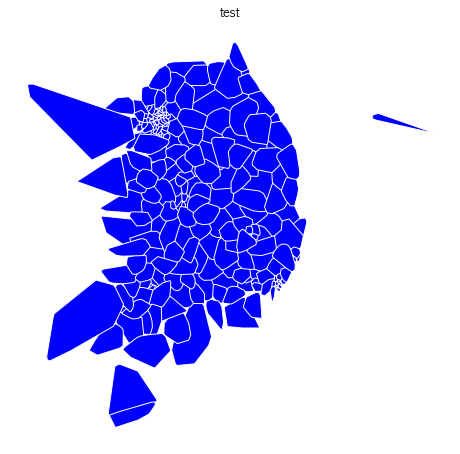

In [30]:
# 지도 테스트(읍면동
ax = emd.convex_hull.plot(color='blue', edgecolor="w")
ax.set_axis_off()
ax.set_title('test')
plt.rcParams['figure.figsize']=(8,8)
plt.show()
# 시군구 이름 겹치는건...